# Landsat 8 Geomedian Dashboard

__Background:__ [Landsat 8](https://landsat.usgs.gov/landsat-8) data is available from April 2013 onwards. The geometric median ([geomedian](http://ieeexplore.ieee.org/document/8004469/)) is a statistical composite of satellite data showing a spatial median state for the area and can be used to look at the statistical average behavior of an area for the time chosen.

__Before you run this notebook:__ This notebook uses the dea statistics module. You need to run "module load dea" in a terminal window and then launch jupyter notebooks in the same window so that your notebook can 'see' the stats module.

__What does this notebook do?:__ This notebook interactively creates a composite of Landsat 8 data. You can then save the data as a png image, netcdf and geotiff.

__Date:__ May 2018

__Authors:__ Bex Dunn, Vanessa Newey, Josh Sixsmith, Erin Telfer

### importing modules

In [1]:
import pandas as pd
import xarray as xr
import datetime #for widget date validation
import numpy as np
import datacube #modules for datacube and dea stats
#test geotiff writer function
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube_stats.statistics import GeoMedian
dc = datacube.Datacube(app='dc-tcw and geomedian')
import fiona
import shapely.geometry
import rasterio.features
import rasterio
from datacube.utils import geometry
import matplotlib.pyplot as plt
from ipywidgets import interact #for widgets
from IPython.display import display
import ipywidgets as widgets
import os
from skimage import exposure #check if you still need this after you add external fns
from matplotlib.pyplot import imshow
from datacube.storage.storage import write_dataset_to_netcdf
import sys
sys.path.append(os.path.abspath('/g/data/r78/vmn547/reference/GWandDEA_bex_ness'))
from FileDialogs import *
#from bex_functions import *
#ignore datacube warnings
import warnings
warnings.filterwarnings('ignore', module='datacube')
global NBART_GM
global GEOM
global SHAPE_NAME
GEOM = None
SHAPE_NAME =None

### Defining functions

In [2]:
def open_polygon_from_shapefile(shapefile, index_of_polygon_within_shapefile=0):
    '''hide the messy process of getting a polygon input, opening it using fiona and getting the geopolygon out of it for the datacube query 
    within this function. It will also make sure you have the correct crs object for the DEA'''

    # open all the shapes within the shape file
    shapes = fiona.open(shapefile)
    i =index_of_polygon_within_shapefile
    #print('shapefile index is '+str(i))
    if i > len(shapes):
        print('index not in the range for the shapefile'+str(i)+' not in '+str(len(shapes)))
        sys.exit(0)
    #copy attributes from shapefile and define shape_name
    geom_crs = geometry.CRS(shapes.crs_wkt)
    geo = shapes[i]['geometry']
    geom = geometry.Geometry(geo, crs=geom_crs)
    geom_bs = shapely.geometry.shape(shapes[i]['geometry'])
    shape_name = shapefile.split('/')[-1].split('.')[0]+'_'+str(i)
    #print('the name of your shape is '+shape_name)
    #get your polygon out as a geom to go into the query, and the shape name for file names later
    return geom, shape_name

In [3]:
def load_nbart(sensor,query, bands_of_interest): 
    '''loads nbart data for a sensor, masks using pq, then filters out terrain -999s
    function written 23-08-2017 based on dc v1.5.1'''  
    dataset = []
    product_name = '{}_{}_albers'.format(sensor, 'nbart')
    print('loading {}'.format(product_name))
    ds = dc.load(product=product_name, measurements=bands_of_interest,
                 group_by='solar_day', **query)
    #grab crs defs from loaded ds if ds exists
    if ds:
        crs = ds.crs
        affine = ds.affine
        print('loaded {}'.format(product_name))
        mask_product = '{}_{}_albers'.format(sensor, 'pq')
        sensor_pq = dc.load(product=mask_product, fuse_func=ga_pq_fuser,
                            group_by='solar_day', **query)
        if sensor_pq:
            print('making mask {}'.format(mask_product))
            cloud_free = masking.make_mask(sensor_pq.pixelquality,
                                           cloud_acca='no_cloud',
                                           cloud_shadow_acca = 'no_cloud_shadow',                           
                                           cloud_shadow_fmask = 'no_cloud_shadow',
                                           cloud_fmask='no_cloud',
                                           blue_saturated = False,
                                           green_saturated = False,
                                           red_saturated = False,
                                           nir_saturated = False,
                                           swir1_saturated = False,
                                           swir2_saturated = False,
                                           contiguous=True)
            ds = ds.where(cloud_free)
            ds.attrs['crs'] = crs
            ds.attrs['affine'] = affine
            print('masked {} with {} and filtered terrain'.format(product_name,mask_product))
            # nbarT is correctly used to correct terrain by replacing -999.0 with nan
            ds=ds.where(ds!=-999.0)
        else: 
            print('did not mask {} with {}'.format(product_name,mask_product))
    else:
        print ('did not load {}'.format(product_name)) 

    if len(ds)>0:
        return ds
    else:
        return None

In [4]:
def drawTrueColour(ds, time = 0):
    '''code by Mike Barnes Feb 2018 draws true color plots. 
    altered by bex for drawing composites with no time dimension'''
    #t, y, x = ds['red'].shape
    y, x = ds['red'].shape
    rawimg = np.zeros((y,x,3), dtype = np.float32)
    for i, colour in enumerate(['red','green','blue']):
        #rawimg[:,:,i] = ds[colour][time].values
        rawimg[:,:,i] = ds[colour].values
    rawimg[rawimg == -999] = np.nan
    img_toshow = exposure.equalize_hist(rawimg, mask = np.isfinite(rawimg))
    fig = plt.figure(figsize=[10,10])
    imshow(img_toshow)
    ax = plt.gca()
    #ax.set_title(str(ds.time[time].values))


In [5]:
def write_your_netcdf(data, dataset_name, filename, crs):
    '''this function turns an xarray dataarray into a dataset so we can write it to netcdf. It adds on a crs definition
    from the original array. data = your xarray dataset, dataset_name is a string describing your variable'''    
    #turn array into dataset so we can write the netcdf
    if isinstance(data,xr.DataArray):
        dataset= data.to_dataset(name=dataset_name)
    elif isinstance(data,xr.Dataset):
        dataset = data
    else:
        print('your data might be the wrong type, it is: '+type(data))
    #grab our crs attributes to write a spatially-referenced netcdf
    dataset.attrs['crs'] = crs
    #dataset.attrs['affine'] =affine
    #dataset.dataset_name.attrs['crs'] = crs
    try:
        write_dataset_to_netcdf(dataset, filename)
    except RuntimeError as err:
        print("RuntimeError: {0}".format(err))        

In [6]:
def write_your_geotiff(filename, data):
    '''this function uses rasterio and numpy to write a multi-band geotiff for one timeslice, or for
    a single composite image. It assumes the input data is an xarray dataset (note, dataset not dataarray)
    and that you have crs and affine objects attached, and that you are using float data. future users
    may wish to assert that these assumptions are correct. Bex Dunn+ Josh Sixsmith 260218'''
    
    kwargs = {'driver': 'GTiff', 'count': len(data.data_vars),#geomedian no time dim
              'width': data.sizes['x'], 'height': data.sizes['y'],
              'crs' : data.crs.crs_str,
              'transform':data.affine,
              'dtype': data.blue.values.dtype,
              'nodata': 0,'compress': 'deflate', 'zlevel': 4, 'predictor': 3 }#for ints use 2 for floats use 3}

    with rasterio.open(filename, 'w', **kwargs) as src:
        for i, band in enumerate(data.data_vars):
            src.write(data[band].data, i+1)


## Select a shape file for your area of analysis
#### if this is larger than 20km x 20km or your time period is long, you may run out of memory

In [7]:
#code to work with an input polygon
style = {'description_width': 'initial'}
shape_file = '/g/data1a/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/fels_sml.shp'
shape_file_text = widgets.Text(value=shape_file,placeholder='update this field',
    description='path to shape file',
    style = {'description_width': 'initial'},                          
    disabled=False,
    layout=widgets.Layout(width='70%'))
def handle_shape_file(sender):
    shape_file=shape_file_text.value
shape_file_text.observe(handle_shape_file)
#display(shape_file_text)

In [8]:
f = SelectFileButton()
def handle_file_selector(sender):
    shape_file_text.value = f.file
f.on_click(handle_file_selector)
display(widgets.HBox([shape_file_text,f],disabled=False))


HBox(children=(Text(value='/g/data1a/r78/rjd547/groundwater_activities/Burdekin/Burdekin_shapefiles/fels_sml.shp', description='path to shape file', layout=Layout(width='70%'), placeholder='update this field', style=DescriptionStyle(description_width='initial')), SelectFileButton(description='Select File', icon='square-o', style=ButtonStyle(button_color='orange'))))

### check if shapefile is valid

In [9]:
button =widgets.Button(
    description='Check shapefile',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

def on_button_clicked(b):
    #check whether shapefile is a valid shapefile and exists
    if not os.path.isfile(shape_file_text.value):
        print('this is not a shapefile')
    else:
        try:
            with fiona.open(shape_file_text.value, 'r') as input:
            # check that the file type is a shapefile
                if input.driver == 'ESRI Shapefile':
                    global GEOM
                    global SHAPE_NAME
                    GEOM, SHAPE_NAME = open_polygon_from_shapefile(shape_file_text.value)
                    print ("Specified file is a Shapefile!")
                else:
                    print ("NOT a Shapefile!")
        except:
            print ("NOT a Shapefile!")

    #shapes = fiona.open(shape_file)
button.on_click(on_button_clicked)
display(button)

Button(description='Check shapefile', style=ButtonStyle(), tooltip='Click me')

Specified file is a Shapefile!


### Or Draw query shape on the map below

In [10]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps
)

import plotly.plotly as py
from traitlets import link
import ipywidgets as widgets
from datacube.utils import geometry
#center = [-12.543839666237682, 131.08474731445315]
center =[-20.0183,145.3134]
zoom = 10


m = Map(center=center, zoom=zoom,layout=dict(width='400px', height='400px'))

#Let's draw a second map 

m2 = Map(center=center, zoom=zoom, basemap=basemaps.Esri.WorldImagery,layout=m.layout)


# Now create the DrawControls and add it to the Maps using add_control. 
# We also register handlers for draw events. These will fire when a polygon is drawn created, edited or deleted 
# (there are the actions). The geo_json argument is the serialized geometry of the drawn path, 
# along with its embedded style.

draw_control = DrawControl(polyline={})
draw_control2 = DrawControl(polygon={'shapeOptions': {'color': '#0000FF'}}, polyline={})
def handle_draw(self, action, geo_json):
    if action == 'created':
        m2.add_layer(GeoJSON(data=draw_control.last_draw))
        draw_control2.last_draw =draw_control.last_draw
    if action == 'deleted':
        while len(m2.layers)>1:
            m2.remove_layer(m2.layers[1])

def handle_draw2(self, action, geo_json):
    
    if action == 'created':
        m.add_layer(GeoJSON(data=draw_control2.last_draw))
        draw_control.last_draw =draw_control2.last_draw
    if action == 'deleted':
        while len(m.layers)>1:
            m.remove_layer(m.layers[1])
            
#add handlers to draw controls  
draw_control.on_draw(handle_draw)
draw_control2.on_draw(handle_draw2)

#add draw controls to maps
m.add_control(draw_control)
m2.add_control(draw_control2)

#We can use link to synchronize traitlets of the two maps:

map_center_link = link((m, 'center'), (m2, 'center'))
map_zoom_link = link((m, 'zoom'), (m2, 'zoom'))

#use_map_geom_button = widgets.Button(description="Use Drawn Geom")

use_map_geom_button = widgets.ToggleButtons(
    options=['Shapefile', 'DrawnPolygon'],
    description='Geometry Used for Datacube Query:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Use Shapefile Specified for the DC query', 'Use Polygon Drawn on the Map for the DC query'],
#     icons=['check'] * 3
)

def on_map_button_click(b):
    global GEOM
    global SHAPE_NAME
    #Leaflet return geometry in EPSG:4326
    geom_crs = geometry.CRS('EPSG:4326') 
    if use_map_geom_button.value == "Shapefile":
        GEOM, SHAPE_NAME = open_polygon_from_shapefile(shape_file_text.value)
    else:
        try:
            GEOM=geometry.Geometry(draw_control.last_draw['geometry'], geom_crs)
            SHAPE_NAME = "drawn_polygon"
        except:
            print("Draw a polygon first.")

use_map_geom_button.on_trait_change(on_map_button_click)


from ipywidgets import HBox, VBox
h_box= HBox([m,m2])

VBox([h_box,use_map_geom_button])

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:89: DeprecationWarning:

on_trait_change is deprecated in traitlets 4.1: use observe instead



VBox(children=(HBox(children=(Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[-20.0183, 145.3134], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {}}),), default_tiles=TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']), layers=(TileLayer(max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size']),), layout=Layout(height='400px', width='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=10), Map(basemap={'url': 'http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}', 'max_zoom': 20, 'attribution': 'Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', 'name': 'Esri.WorldImagery'}, center=[-20.0183, 145.3134], controls=(DrawControl(layer=FeatureGroup(), polygon={'shapeOptions': {'color': '#0000FF'}}),), default_tiles=TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'), layers=(TileLayer(attribution='Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community', max_zoom=20, min_zoom=1, name='Esri.WorldImagery', options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'opacity', 'tile_size'], url='http://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}'),), layout=Layout(height='400px', width='400px'), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'], zoom=10))), ToggleButtons(description='Geometry Used for Datacube Query:', options=('Shapefile', 'DrawnPolygon'), tooltips=['Use Shapefile Specified for the DC query', 'Use Polygon Drawn on the Map for the DC query'], value='Shapefile')))

### epoch of interest 

In [11]:
SHAPE_NAME

In [12]:
#Set a standard time range for people to change as desired
start_of_epoch = '2013-04-01'
end_of_epoch =  '2013-05-31'

#create a date picker widget for the start date
from_date_picker = widgets.Text(value=start_of_epoch,
                                placeholder='update this field YYYY-MM-DD',
    description='start date',
    disabled=False)

#define a function to check the start date
def handle_from_date(sender):
    '''takes the start of epoch date from the date picker and checks it is in the 
    correct format'''
    start_of_epoch=from_date_picker.value
    validate(start_of_epoch)
    
#when you press enter this runs the event handler (handle_from_date)    
from_date_picker.on_submit(handle_from_date)

#create a date picker widget for the end date
to_date_picker = widgets.Text(value = end_of_epoch,
                              placeholder='update this field YYYY-MM-DD',
    description='end date',
    disabled=False)

def handle_to_date(sender):
    '''takes the end of epoch date from the date picker and checks it is in the 
    correct format'''
    end_of_epoch = to_date_picker.value
    validate(end_of_epoch)
    
#when you press enter this runs the event handler (handle_to_date)    
to_date_picker.on_submit(handle_to_date)

#make a validation button to validate the dates
#first write the function the button runs
def validate(date_text):
    '''this function checks to see whether your text is year-month-day formatted'''
    try:
        datetime.datetime.strptime(date_text, '%Y-%m-%d')
        return True    
    except ValueError:
        return False
    
#make the button run the function to check the dates
button_epoch =widgets.Button(
    description='Check dates',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
)

#This widget prints whether or not your start date is valid
starttextwidget = widgets.Label(
value='Is my start date valid?'
)

#This widget prints whether or not your end date is valid
endtextwidget = widgets.Label(
value='Is my end date valid?'
)

#this is the event handler for when you click on the button
def on_button_end_epoch_clicked(button):
    '''check whether the dates are in the format we need'''
    if not validate(to_date_picker.value):
        endtextwidget.value = ('Incorrect data format, should be YYYY-MM-DD')
    else:
        validate(to_date_picker.value)
        endtextwidget.value = ('End date is valid')
        
 
    if not validate(from_date_picker.value):
        starttextwidget.value = ('Incorrect data format, should be YYYY-MM-DD')
    else:
        validate(from_date_picker.value)
        starttextwidget.value = ('Start date is valid')
        start_of_epoch = from_date_picker.value
    
    
button_epoch.on_click(on_button_end_epoch_clicked)

#display widgets next to each other
end_hbox = widgets.HBox([to_date_picker, endtextwidget])
start_hbox = widgets.HBox([from_date_picker, starttextwidget])
display(start_hbox,end_hbox)
display(button_epoch)

HBox(children=(Text(value='2013-04-01', description='start date', placeholder='update this field YYYY-MM-DD'), Label(value='Is my start date valid?')))

HBox(children=(Text(value='2013-05-31', description='end date', placeholder='update this field YYYY-MM-DD'), Label(value='Is my end date valid?')))

Button(description='Check dates', style=ButtonStyle(), tooltip='Click me')

### load the data and calulate the geomedian

In [13]:
loadButton = widgets.Button(description="Load and Calculate")

def on_load_button_clicked(b):
    start_of_epoch = from_date_picker.value
    end_of_epoch = to_date_picker.value
    global GEOM
    global SHAPE_NAME
    if GEOM is None:
        GEOM, SHAPE_NAME = open_polygon_from_shapefile(shape_file_text.value)
       
    
    #Define wavelengths/bands of interest, remove this kwarg to retrieve all bands
    bands_of_interest = ['blue',
                         'green',
                         'red',
                         'nir',
                         'swir1',
                         'swir2'
                         ]

    query = {
        'time': (start_of_epoch, end_of_epoch), 'geopolygon': GEOM,
    }

    #this is done separately instead of in a loop because the datasets can be quite large.
    #currently this is a way of memory handling -there is probably a better way of doing it.
    #sensor1_nbart=load_nbart('ls5',query, bands_of_interest)
    #sensor2_nbart=load_nbart('ls7',query,bands_of_interest)
    sensor3_nbart=load_nbart('ls8',query, bands_of_interest)
    
    nbart=sensor3_nbart.sortby('time')
    #geomedian transform
    global NBART_GM
    NBART_GM=GeoMedian().compute(nbart)
    print("Geomedian calculated")

loadButton.on_click(on_load_button_clicked)
display(loadButton)

Button(description='Load and Calculate', style=ButtonStyle())

loading ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.



loaded ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning:

casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning:

calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.



making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain
Geomedian calculated
loading ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning:

casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.



loaded ls8_nbart_albers


/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning:

casting an xarray.Dataset to a boolean will change in xarray v0.11 to only include data variables, not coordinates. Cast the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.

/g/data/v10/public/modules/agdc-py3-env/20171214/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:42: FutureWarning:

calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.



making mask ls8_pq_albers
masked ls8_nbart_albers with ls8_pq_albers and filtered terrain
Geomedian calculated


## A true color plot of the geomedian composite:

Button(description='Plot Geomedian', style=ButtonStyle())

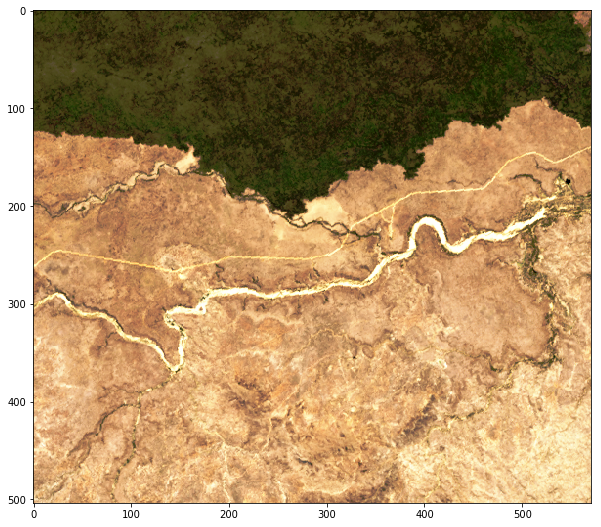

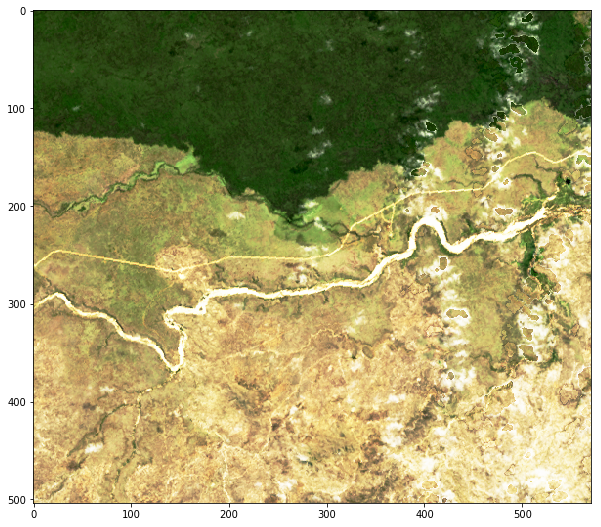

In [14]:
plotButton = widgets.Button(description="Plot Geomedian")
def on_plot_button_click(b):
    global NBART_GM
    drawTrueColour(NBART_GM)
plotButton.on_click(on_plot_button_click)
display(plotButton)

### *Save as netcdf*:

In [15]:
saveFileB = SaveFileButton()
def handle_file_selector(sender):
    filename =saveFileB.file
    global NBART_GM
    write_your_netcdf(NBART_GM,'nbart_gm',filename=filename, crs=NBART_GM.crs)
    print("saved netcdf")
saveFileB.on_click(handle_file_selector)
display(saveFileB)


SaveFileButton(description='Save File As', icon='square-o', style=ButtonStyle(button_color='orange'))

###  Write out to geotiff!!!

In [16]:
saveFileB2 = SaveFileButton()
def handle_file_selector(sender):
    filename =saveFileB2.file
    global NBART_GM
    write_your_geotiff(filename, NBART_GM)
    print("saved geotiff")
saveFileB2.on_click(handle_file_selector)
display(saveFileB2)


SaveFileButton(description='Save File As', icon='square-o', style=ButtonStyle(button_color='orange'))

## You are done. Now go check your files to make sure everything worked!!!

## Check out many more Notebooks and functions to add to Notebooks in: https://github.com/GeoscienceAustralia/dea-notebooks